In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re
import cv2
from pytesseract import Output
import seaborn as sns
import warnings
import pandas as pd  
import datetime
from datetime import date
from datetime import datetime
import urllib.request
from flask import Flask, jsonify, request
warnings.filterwarnings('ignore')

In [24]:
# Utility methods 
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')
def cleanString(value):
    return re.sub(r'[^\w\s]', '', value).strip()
# Extract PanCard details
def extractDetails(extract): 
    userDetails = {}
    for ele in extract:
        if (re.search('Permanent|Account|Number|Card', ele)):
            userDetails["panNumber"] = extracted_text[extracted_text.index(ele)+1].strip()
        elif (re.search("Father|Father's|Name", ele)):
            userDetails["fathersName"] = cleanString(extracted_text[extracted_text.index(ele)+1])
            userDetails["ownersName"] = cleanString(extracted_text[extracted_text.index(ele)-1])
        match = re.search(r'(\d+/\d+/\d+)',ele)
        if(match!=None):
            userDetails["dob"] = match.group(1).strip()
    return userDetails
# Extract PanCard details
def extractDetailsFormat2(extract): 
    userDetails = {}
    for ele in extract:
        if (re.search('Permanent|Account|Number|Card', ele)):
            userDetails["panNumber"] = extracted_text[extracted_text.index(ele)+1].strip()
        if(re.search(r'(\d+/\d+/\d+)',ele)):
            userDetails["dob"] = ele.strip()
            userDetails["fathersName"] = cleanString(extracted_text[extracted_text.index(ele)-1])
            userDetails["ownersName"] = cleanString(extracted_text[extracted_text.index(ele)-2])
    return userDetails


In [25]:
image = None
def get_details(file_link):
    #file_name = 'PanCard1.jpg'
    image = cv2.imread(file_link, cv2.IMREAD_GRAYSCALE) 
    plot_gray(image)

In [26]:
def remove_noise(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)

In [29]:
from skimage.filters import threshold_otsu
if image != None:
    thresh_val = threshold_otsu(image)

In [30]:
mask=np.where(image>thresh_val,1,0)

TypeError: '<' not supported between instances of 'int' and 'NoneType'

Text(0.5, 1.0, 'Masked Image')

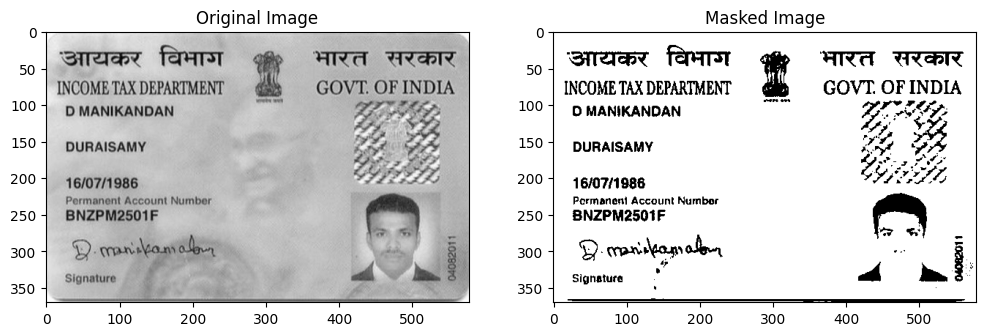

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.title('Original Image')

plt.subplot(1,2,2)
maskimg = mask.copy()
plt.imshow(maskimg, cmap='gray')
plt.title('Masked Image')

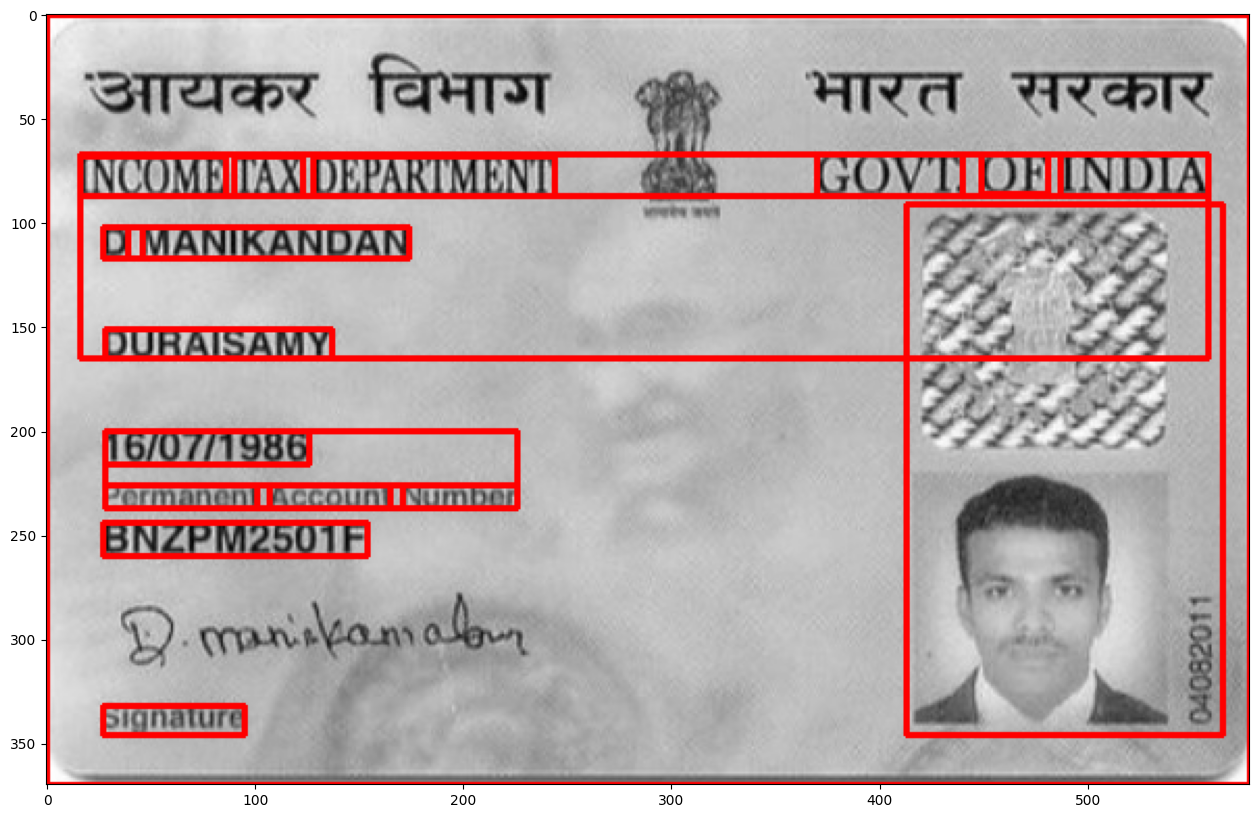

In [ ]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
plot_rgb(boxes)

In [ ]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

INCOME TAX DEPARTMENT GOVT. OF INDIA
D MANIKANDAN
DURAISAMY

16/07/1986
Permanent Account Number

BNZPM2501F

Signature




In [ ]:
extracted_text = extracted_text.strip().split("\n")
extracted_text = [ele for ele in extracted_text if ele.strip()] # removing blank spaces
extracted_text

['INCOME TAX DEPARTMENT GOVT. OF INDIA',
 'D MANIKANDAN',
 'DURAISAMY',
 '16/07/1986',
 'Permanent Account Number',
 'BNZPM2501F',
 'Signature']

In [ ]:
extracted_name = extracted_text[1]
extracted_date = extracted_text[3]
#extracted_date1 = datetime.strptime(extracted_date, '%d/%m/%y')
#extracted_date = datetime.datetime(extracted_text[3])
#extracted_date = extracted_date.strftime('%7/%m/%d')
print(type(extracted_date))
extracted_accno = extracted_text[5]


<class 'str'>


In [ ]:
df = pd.read_excel("PanCard.xlsx")
Name_List = df["Name"].tolist()
PermanentAccountNumber_List  = df["Permanent Account Number "].tolist()
DateofBirth_List = df["Date of Birth"].tolist()


In [ ]:
if extracted_name in Name_List:
        print("Name Verified")
else:
        print("Name Not Verified")

if extracted_text[5] in PermanentAccountNumber_List:
        print("Permanent Account Number Verified")
else:
        print("Permanent Account Number Verified")

if extracted_text[3] in DateofBirth_List:
        print("Date of Birth Verified")
else:
       print("Date of Birth Not Verified")

Name Verified
Permanent Account Number Verified
Date of Birth Not Verified


In [ ]:
if  extracted_name in Name_List and extracted_text[5] in PermanentAccountNumber_List and extracted_text[3] in DateofBirth_List:
    print("Verified")
else:
    print("Not Verified")

Not Verified


In [ ]:
import cer
from cer import calculate_cer
import jiwer
from jiwer import wer

In [ ]:
cer_score = calculate_cer(extracted_text[1], extracted_name)
print("Cer Score", cer_score)


Cer Score 0.0


In [ ]:
error = wer(extracted_text[5], extracted_name)
print(error)

2.0


In [ ]:
app = Flask(__name__)

@app.route('/PanCard',methods=['GET'])
def index():
    fileLink = request.args.get("fileLink")
    print(fileLink)
    get_details(fileLink)
    if  extracted_name in Name_List and extracted_text[5] in PermanentAccountNumber_List and extracted_text[3] in DateofBirth_List:
        return"Verified"
    else:
        return"Not Verified"

if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [30/Apr/2023 18:03:33] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [30/Apr/2023 18:03:43] "GET /PanCard?fileLink=https://firebasestorage.googleapis.com/v0/b/ai-in-ecommerce.appspot.com/o/Documents%2FResume_Barclays_18_3_23.pdf?alt=media%26token=9daeca91-6557-4d41-99ca-64d78b1667fd HTTP/1.1" 200 -


https://firebasestorage.googleapis.com/v0/b/ai-in-ecommerce.appspot.com/o/Documents/Resume_Barclays_18_3_23.pdf?alt=media&token=9daeca91-6557-4d41-99ca-64d78b1667fd
